In [1]:
# Phone Bank Pick-up Rate Analysis
# by Dov Salkoff, 12/25/20

# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import raw data
dataRaw = pd.read_csv('Phonebank Pick-up Rate Data - Data.csv')
# rename some columns
dataRaw = dataRaw.rename(columns={"Department (leave blank if multiple)": "Department"})
dataRaw = dataRaw.rename(columns={"Area Code used to call": "Area code"})

# add Weekday column
import datetime
weekday = []
for row in dataRaw.index:
    dt = dataRaw.at[row,'Date']
    month, day, year = (int(x) for x in dt.split('/'))
    ans = datetime.date(year, month, day)
    weekday.append(ans.strftime("%A"))
dataRaw['Weekday'] = weekday
dataRaw.head(8)

,Caller (optional),Date,Time,Area code,Department,Calls attempted,Calls answered,Committed to sign,Graduated,"Call Durations (optional, non-graduated only)",Notes,Weekday
0,Dov,12/16/2020,5-6 PM,530,Chemical and Materials Science Engineering,14,5,0.0,1.0,NaN,NaN,Wednesday
1,Dov,12/16/2020,6-7 PM,530,Civil Engineering,1,1,0.0,1.0,NaN,NaN,Wednesday
2,Dov,12/18/2020,12-1 PM,530,Civil Engineering,19,8,0.0,3.0,NaN,NaN,Friday
3,Dov,12/18/2020,1-2 PM,530,Civil Engineering,7,2,0.0,0.0,NaN,NaN,Friday
4,Dov,12/18/2020,3-4 PM,530,Civil Engineering,11,1,0.0,0.0,NaN,NaN,Friday
5,Dov,12/18/2020,4-5 PM,475,Civil Engineering,21,2,0.0,0.0,NaN,NaN,Friday
6,Dov,12/18/2020,4-5 PM,530,Civil Engineering,1,1,1.0,0.0,NaN,NaN,Friday
7,Dov,12/18/2020,5-6 PM,530,Civil Engineering,8,1,1.0,0.0,NaN,NaN,Friday


22.3% of calls answered


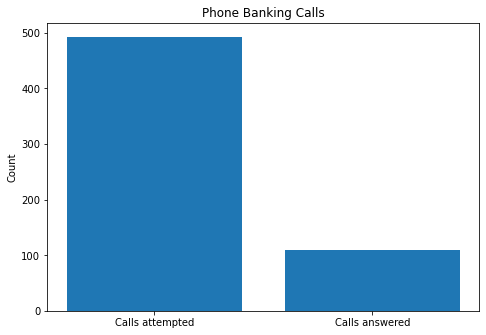

In [3]:
# Data exploration
# bar chart of all attempted / answered calls

total_attempted = round(dataRaw['Calls attempted'].sum())
total_answered = round(dataRaw['Calls answered'].sum())
print(f'{total_answered/total_attempted*100:.1f}% of calls answered')

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
callType = ['Calls attempted', 'Calls answered']
callCount = [total_attempted, total_answered]
ax.bar(callType,callCount)
ax.set_ylabel('Count')
ax.set_title('Phone Banking Calls')
plt.show()

In [4]:
# Prepare for regression analysis
# make X and y variables
# one element for each call attempt (observation)

# dependent variable: if call answered, True. Otherwise False
y = [False]*total_attempted # pre-allocate
counterCall = 0
for row in dataRaw.index:
    answered = round(dataRaw.at[row,'Calls answered'])
    y[counterCall:counterCall+answered] = [True]*answered
    counterCall = counterCall + dataRaw.at[row,'Calls attempted']

# independent variables
reps = [val for val in dataRaw['Calls attempted']]
dataNew = dataRaw.loc[np.repeat(dataRaw.index.values, reps)]
dataNew = dataNew.reset_index()
dataNew = dataNew[['Time', 'Area code', 'Department', 'Weekday']]
dataNew['bAnswered'] = y
# dataNew.to_csv('AllCalls.csv')

In [5]:
# Pick-up rate by weekday
prob = dataNew[['bAnswered', 'Weekday']].groupby('Weekday').mean()
probError = dataNew[['bAnswered', 'Weekday']].groupby('Weekday').sem()
count = dataNew[['Weekday']].value_counts()
tab = pd.merge(prob['bAnswered'], count.reset_index(), on='Weekday')
tab = pd.merge(tab, probError['bAnswered'], on='Weekday')
tab = tab.rename(columns={'bAnswered_x': 'Pick-up Rate', 0: 'Count', 'bAnswered_y': 'std err'})
tab = tab.set_index('Weekday')
tab = tab.reindex(['Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday'])
tab

,Pick-up Rate,Count,std err
Weekday,,,
Monday,0.270833,48,0.064821
Tuesday,0.206349,126,0.036196
Wednesday,0.227586,145,0.034940
Thursday,0.150000,20,0.081918
Friday,0.227273,154,0.033880


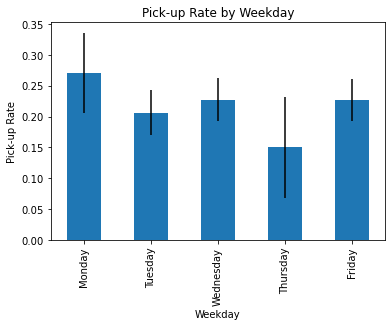

In [6]:
ax = tab.plot.bar(y='Pick-up Rate', yerr='std err', ylabel='Pick-up Rate', legend=False, title='Pick-up Rate by Weekday')

In [7]:
# Pick-up rate by time
prob = dataNew[['bAnswered', 'Time']].groupby('Time').mean()
probError = dataNew[['bAnswered', 'Time']].groupby('Time').sem()
count = dataNew[['Time']].value_counts()
tab = pd.merge(prob['bAnswered'], count.reset_index(), on='Time')
tab = pd.merge(tab, probError['bAnswered'], on='Time')
tab = tab.rename(columns={'bAnswered_x': 'Pick-up Rate', 0: 'Count', 'bAnswered_y': 'std err'})
tab = tab.set_index('Time')
tab = tab.reindex(['11 AM-12 PM', '12-1 PM', '1-2 PM', '2-3 PM', '3-4 PM', '4-5 PM', '5-6 PM', '6-7 PM'])
tab.to_csv('Pick-up rate by time.csv')
tab.head()

,Pick-up Rate,Count,std err
Time,,,
11 AM-12 PM,0.090909,55,0.039121
12-1 PM,0.379310,29,0.091697
1-2 PM,0.388889,18,0.118236
2-3 PM,0.288462,52,0.063439
3-4 PM,0.150000,20,0.081918


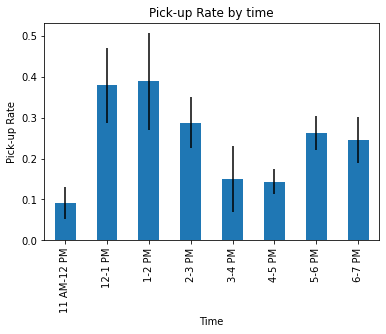

In [8]:
ax = tab.plot.bar(y='Pick-up Rate', yerr='std err', ylabel='Pick-up Rate', legend=False, title='Pick-up Rate by time')

In [9]:
# Pick-up rate by area code
prob = dataNew[['bAnswered', 'Area code']].groupby('Area code').mean()
count = dataNew[['Area code']].value_counts()
tab = pd.merge(prob['bAnswered'], count.reset_index(), on='Area code')
tab = tab.rename(columns={'bAnswered': 'Pick-up Rate', 0: 'Count'})
tab = tab.set_index('Area code')
tab

,Pick-up Rate,Count
Area code,,
314,0.215054,93
475,0.095238,21
503,0.375000,16
530,0.220963,353
916,0.400000,10


In [10]:
# Pick-up rate by department
prob = dataNew[['bAnswered', 'Department']].groupby('Department').mean()
count = dataNew[['Department']].value_counts()
tab = pd.merge(prob['bAnswered'], count.reset_index(), on='Department')
tab = tab.rename(columns={'bAnswered': 'Pick-up Rate', 0: 'Count'})
tab.sort_values(by=['Pick-up Rate'], ascending=False)

,Department,Pick-up Rate,Count
0,ARE,0.666667,3
11,Plant Pathology,0.400000,15
5,Ecology,0.375000,16
8,Immunology,0.333333,6
9,Math,0.285714,7
6,Entomology and Nematology,0.238095,21
4,Civil Engineering,0.234899,149
3,Chemical and Materials Science Engineering,0.225000,40
1,Biological & Agricultural Engineering,0.210526,76
10,Mechanical and Aerospace Engineering,0.194805,77


In [11]:
# Test if proportion of answered calls is higher at noon than 4pm
# (proportions test)
from statsmodels.stats.proportion import proportions_ztest

nobs12 = dataNew[['bAnswered', 'Time']].groupby('Time').count().loc['12-1 PM'].to_numpy()
nobs4 = dataNew[['bAnswered', 'Time']].groupby('Time').count().loc['4-5 PM'].to_numpy()
count12 = dataNew[['bAnswered', 'Time']].groupby('Time').sum().loc['12-1 PM'].to_numpy()
count4 = dataNew[['bAnswered', 'Time']].groupby('Time').sum().loc['4-5 PM'].to_numpy()

count = np.concatenate((count12, count4))
nobs = np.concatenate((nobs12, nobs4))
stat, pval = proportions_ztest(count, nobs, 0, 'two-sided')
print('p-value= {0:0.3f}'.format(pval))

p-value= 0.003


In [12]:
# Test if proportion of answered calls is higher with 530 area code

nobsArea530 = dataNew[['bAnswered', 'Area code']].groupby('Area code').count().loc[530].to_numpy()
nobsArea475 = dataNew[['bAnswered', 'Area code']].groupby('Area code').count().loc[475].to_numpy()
countArea530 = dataNew[['bAnswered', 'Area code']].groupby('Area code').sum().loc[530].to_numpy()
countArea475 = dataNew[['bAnswered', 'Area code']].groupby('Area code').sum().loc[475].to_numpy()

count = np.concatenate((countArea530, countArea475))
nobs = np.concatenate((nobsArea530, nobsArea475))
stat, pval = proportions_ztest(count, nobs, 0, 'two-sided')
print('p-value= {0:0.3f}'.format(pval))

p-value= 0.172


In [13]:
# Create dummy variables

dataDummies = dataNew
cat_vars = list(dataNew.columns)[0:-1]
for var in cat_vars:
    cat_list = pd.get_dummies(dataNew[var], prefix=var)
    dataDummies=dataDummies.join(cat_list)

data_vars=dataDummies.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
dataFinal=dataDummies[to_keep]
dataFinal.columns.values

array(['bAnswered', 'Time_1-2 PM', 'Time_1-3 PM', 'Time_11 AM-12 PM',
       'Time_12-1 PM', 'Time_2-3 PM', 'Time_3-4 PM', 'Time_4 - 6 PM',
       'Time_4-5 PM', 'Time_5-6 PM', 'Time_6-7 PM', 'Area code_314',
       'Area code_475', 'Area code_503', 'Area code_530', 'Area code_916',
       'Department_ARE',
       'Department_Biological & Agricultural Engineering',
       'Department_Biomedical Engineering',
       'Department_Chemical and Materials Science Engineering',
       'Department_Civil Engineering', 'Department_Ecology',
       'Department_Entomology and Nematology', 'Department_Epidemiology',
       'Department_Immunology', 'Department_Math',
       'Department_Mechanical and Aerospace Engineering',
       'Department_Plant Pathology', 'Weekday_Friday', 'Weekday_Monday',
       'Weekday_Thursday', 'Weekday_Tuesday', 'Weekday_Wednesday'],
      dtype=object)

In [14]:
# Split data into train and test sets

X = dataFinal.loc[:, dataFinal.columns != 'bAnswered']
y = dataFinal.loc[:, dataFinal.columns == 'bAnswered']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

# Our dataset is highly imbalanced (there are many more unanswered than answered calls)
# Over-sample training data (under-represented class) using SMOTENC
# Good explanation of SMOTE here: 
# https://rikunert.com/SMOTE_explained

from imblearn.over_sampling import SMOTENC
idxCategoricalFeature = list(range(1,len(dataFinal.columns.values)-1)) # indices for all vars except bAnswered
os = SMOTENC(random_state=0, categorical_features=idxCategoricalFeature)
os_data_X,os_data_y=os.fit_resample(X_train, y_train)

# Check the numbers of our over-sampled data
print("length of oversampled data is ",len(os_data_X))
print("Number of no answer in oversampled data",len(os_data_y[os_data_y['bAnswered']==0]))
print("Number of answered",len(os_data_y[os_data_y['bAnswered']==1]))
print("Proportion of not answered data in oversampled data is ",len(os_data_y[os_data_y['bAnswered']==0])/len(os_data_X))
print("Proportion of answered data in oversampled data is ",len(os_data_y[os_data_y['bAnswered']==1])/len(os_data_X))

# double check no weird values
# os_data_X['Time_2-3 PM'].unique()
# dataFinal['Time_2-3 PM'].unique()

length of oversampled data is  530
Number of no answer in oversampled data 265
Number of answered 265
Proportion of not answered data in oversampled data is  0.5
Proportion of answered data in oversampled data is  0.5


In [15]:
# Consider dropping any variables that don't have more than 3 observations
myDroppedCols = []
myVars = os_data_X.columns.to_list()
for var in myVars:
    # print(var)
    d = os_data_X[var].value_counts()
    # print(d)
    if d[1] < 3:
        myDroppedCols.append(var)
    
print(f'Drop columns? {myDroppedCols}')

Drop columns? ['Department_ARE']


In [16]:
# Train logistic regression model
# take out some columns so X matrix isn't singular
# these will be our reference variables
# if n observations is low, best to make the reference the variable with the most observations

myCols = ['Area code_530', 'Area code_314', 'Time_11 AM-12 PM', 'Time_12-1 PM', 'Time_1-2 PM', 'Time_2-3 PM', 'Time_3-4 PM', 'Time_5-6 PM', 'Time_6-7 PM',
         'Weekday_Monday', 'Weekday_Tuesday', 'Weekday_Wednesday', 'Weekday_Thursday',
         'Department_Mechanical and Aerospace Engineering', 'Department_Civil Engineering']

os_data_X2 = os_data_X[myCols]

# Fit model
import statsmodels.api as sm
os_data_X2 = sm.add_constant(os_data_X2) # add constant term - statsmodels doesn't automatically include y-intercept
logit_model=sm.Logit(os_data_y,os_data_X2) 
result=logit_model.fit(method='lbfgs', maxiter=1000)
# result=logit_model.fit_regularized(maxiter=1000, method='l1', alpha=0.01)
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:              bAnswered   No. Observations:                  530
Model:                          Logit   Df Residuals:                      514
Method:                           MLE   Df Model:                           15
Date:                Wed, 20 Jan 2021   Pseudo R-squ.:                  0.1067
Time:                        20:48:42   Log-Likelihood:                -328.18
converged:                       True   LL-Null:                       -367.37
Covariance Type:            nonrobust   LLR p-value:                 1.382e-10
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
const                                               0.6931      0.283      2.445      0.014       0.138       1.249
Area code_530       

In [17]:
# Predicting the test set results and calculating the accuracy
X_test2 = X_test[os_data_X2.columns[1:]]
X_test2 = sm.add_constant(X_test2)
y_pred = result.predict(X_test2)
predictions = np.array(y_pred >= 0.5)
actual = np.reshape(y_test.values,-1)

# Confusion Matrix
true_negative = np.sum(~actual & ~predictions)
true_positive = np.sum(actual & predictions)
false_negative = np.sum(actual & ~predictions)
false_positive = np.sum(~actual & predictions)
confusion_matrix = np.array([[true_negative, false_positive], [false_negative, true_positive]])
print(confusion_matrix)

# Accuracy
accuracy = (confusion_matrix[0,0] + confusion_matrix[1,1]) / confusion_matrix.sum()
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(accuracy))

[[65 53]
 [16 14]]
Accuracy of logistic regression classifier on test set: 0.53


In [18]:
# # Logistic Regression Model Fitting
# # sklearn logistic regression doesn't have ability to find p-values for coefficients
# # https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression#27928411

# from sklearn.linear_model import LogisticRegression
# from sklearn import metrics

# # logreg = LogisticRegression(max_iter=100)
# logreg = LogisticRegression(max_iter=1000, C=1e8)

# logreg.fit(os_data_X, os_data_y.values.ravel())
# model_coeffs = pd.DataFrame(data=logreg.coef_, columns=columns)
# model_coeffs.insert(loc=0, column='Intercept', value=logreg.intercept_)

# print('Model Coefficients')
# model_coeffs

In [19]:
# y_pred = logreg.predict(X_test)
# print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

In [20]:
# # Confusion matrix
# from sklearn.metrics import confusion_matrix
# confusion_matrix = confusion_matrix(y_test, y_pred)
# print(confusion_matrix)

In [21]:
# # Compute precision, recall, F-measure and support
# from sklearn.metrics import classification_report
# print(classification_report(y_test, y_pred))

In [22]:
# # Logistic Regression Model Fitting (try to get same results as statsmodels fit)
# from sklearn.linear_model import LogisticRegression
# from sklearn import metrics

# # logreg = LogisticRegression(max_iter=100)
# logreg = LogisticRegression(max_iter=10000, C=1e8)

# logreg.fit(os_data_X2, os_data_y.values.ravel())
# model_coeffs = pd.DataFrame(data=logreg.coef_, columns=myCols)
# model_coeffs.insert(loc=0, column='Intercept', value=logreg.intercept_)

# print('Model Coefficients')
# model_coeffs

In [23]:
# from sklearn import linear_model
# from scipy import stats

# class LinearRegression(linear_model.LinearRegression):
#     """
#     LinearRegression class after sklearn's, but calculate t-statistics
#     and p-values for model coefficients (betas).
#     Additional attributes available after .fit()
#     are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
#     which is (n_features, n_coefs)
#     This class sets the intercept to 0 by default, since usually we include it
#     in X.
#     """

#     def __init__(self, *args, **kwargs):
#         if not "fit_intercept" in kwargs:
#             kwargs['fit_intercept'] = False
#         super(LinearRegression, self)\
#                 .__init__(*args, **kwargs)

#     def fit(self, X, y, n_jobs=1):
#         self = super(LinearRegression, self).fit(X, y, n_jobs)

#         sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
#         se = np.array([
#             np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X))))
#                                                     for i in range(sse.shape[0])
#                     ])

#         self.t = self.coef_ / se
#         self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
#         return self